# Portfolio Optimization


### Import packages, read the stock data, and print the stocks curves

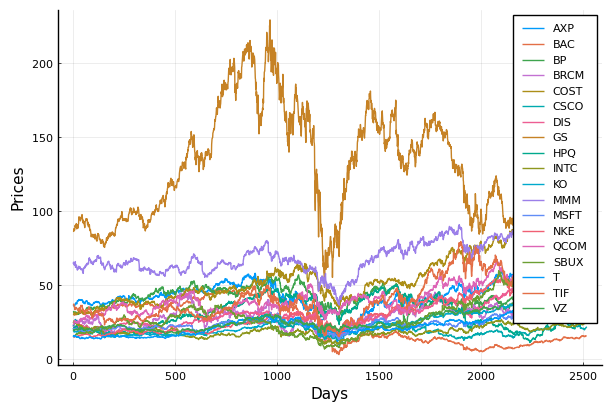

In [31]:
using Plots
using CSV
using DataFrames 
using Statistics     # For computing μ, Σ, ρ, σ
using LinearAlgebra  # Needed by some function in Statistics

pyplot()

data = CSV.read("prices.csv", DataFrame)                # Read the daily prices data from a .csv file and create a DataFrame.
nametags = names(data[:, 1:end-2])                      # Get names of the stocks from first row
nametags = reshape(nametags, 1, length(nametags))       # and convert them into columns            
prices = Matrix(data[1:end, 1:end-2])                   # Last two columns have data and US$ rate
 
## Plot the stock data + add labels
plot(prices, 
     label = nametags,
     grid   = :on,
     xlabel = "Days",
     ylabel = "Prices")

savefig("stockdata.pdf")

### Compute $\mu, \Sigma, \rho,$ and $\sigma$. Sort stocks in increasing order by their expected values $\mu$. Using this order, plot $\mu$ and $\sigma$ as functions of their corresponding stocks.

[0.0006681127397809204, 0.0003890411410037511, 0.00033676148028278515, 0.0004828824677873152, 0.0006518453489825798, 0.00019357680091489332, 0.000681248403764681, 0.0005982922835665234, 0.00034865581180855627, 0.00019987664352140178, 0.00037665165553252695, 0.0004086100439341979, 0.0003853376544840659, 0.0008108370322505913, 0.0006631399290369607, 0.0008684918812743542, 0.00042469895326322676, 0.0006606705621456304, 0.0004644222593082391]

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


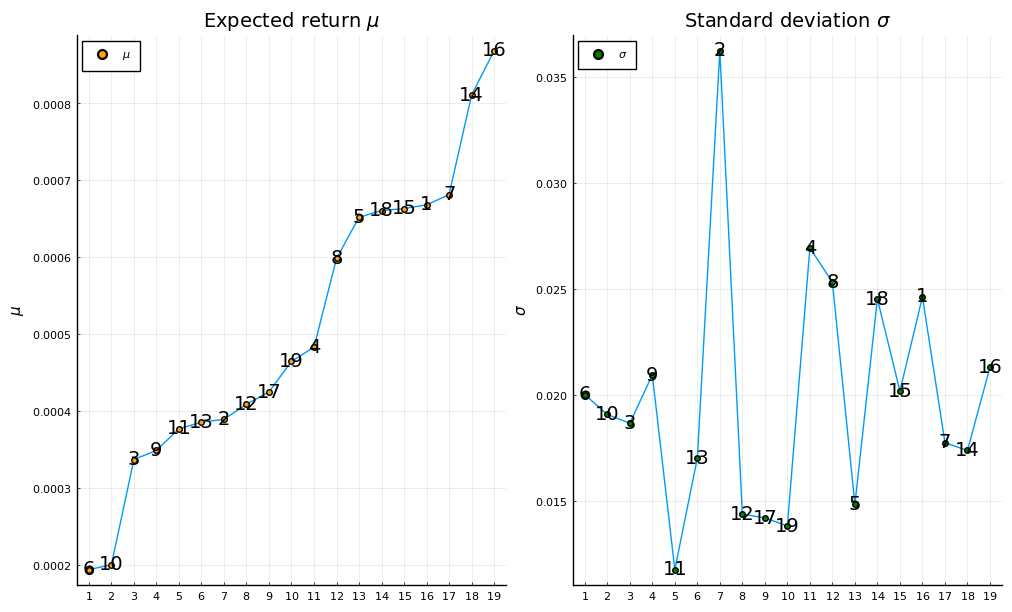

In [32]:
## Relative returns are computed as  100% * (p(t+1) - p(t))/p(t) 
returns = diff(prices, dims = 1) ./ prices[1:end-1,:]

(T, n)  = size(returns)           # Number of days T and stocks n
μ = vec(mean(returns, dims = 1))  # Expected returns
Σ = cov(returns)                  # Covariance matrix
ρ = cor(returns)                  # Correlation matrix
σ = sqrt.(diag(Σ))                # Standard deviation

print(μ)

## Sort stocks by expected return:
ix = sortperm(μ)                  # ix = index ordering (increasing order)
x  = 1:1:n                        #  x = range of all stocks (for plotting) 

## Plot expected return (increasing order)
p1 = plot(x, μ[ix],
          lab    = "",
          xticks = ix,
          ylabel = "\$ \\mu \$",
          series_annotations = string.(ix),
          title  = "Expected return \$ \\mu \$")
## Plot the points separately
scatter!(x, μ[ix], color = :orange, lab = "\$ \\mu \$")

## Plot standard deviation (increasing order w.r.t. μ)
p2 = plot(x, σ[ix], 
          lab    = "",
          xticks = 1:1:n,
          ylabel = "\$ \\sigma \$",
          series_annotations = string.(ix),
          title = "Standard deviation \$ \\sigma \$")
## Plot the points separately
scatter!(x, σ[ix], color = :green, lab = "\$ \\sigma \$")

## Plot both in the same figure     
plot(p1, p2, size = (1000, 600), legend = :topleft)
savefig("mean_std.pdf")

### Visualize the correlation matrix $\rho$ and make a scatterplot of $(\mu_i,\sigma_i),$ for all $i \in N$.

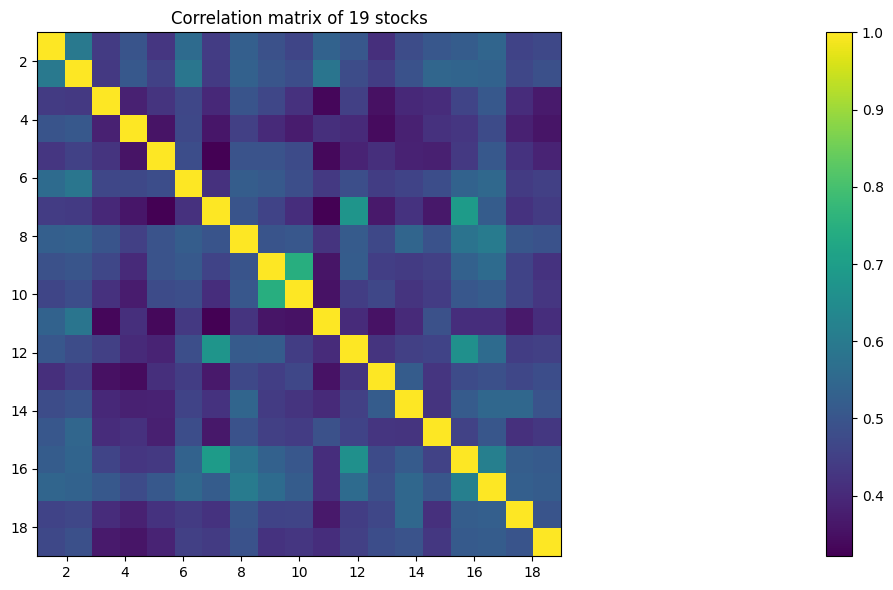

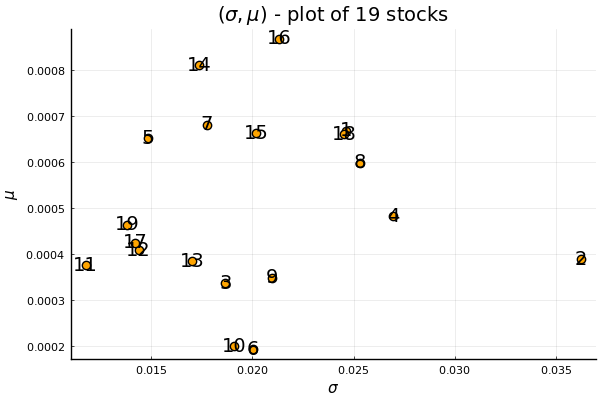

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [33]:
using PyPlot # We will use PyPlot temporary to plot the correlation Matrix
## To refresh memory: ix = index ordering of value of μ (in increasing order)
ix = sortperm(μ)       

## We will visualize the correlation matrix with PyPlot function 'imshow'
figure(figsize = (12,6))
imshow(ρ[ix,ix], extent = [1,19,19,1]);
colorbar(); axis("image")
title("Correlation matrix of $n stocks")
tight_layout()

## We must call PyPlot.savefig() explicitly since we used PyPlot for plotting
PyPlot.savefig("corrmat.pdf")  

### Plot the points (σᵢ, μᵢ) ∀ i ∈ N. NOTE: We are using Plots package functions here again.
## since we loaded both PyPlot and Plots, we need to specify which scatter function we are
## refering to, to avoid ambiguity. Hence the Plots. from here onwards.
Plots.scatter(σ, μ, 
              color = :orange, 
              markersize = 6,
              xlabel = L"$\sigma$",
              ylabel = L"$\mu$",
              lab = "",
              series_annotations = string.(1:n),
              title = L"$(\sigma, \mu)$" * " - plot of $(n) stocks"
)

# savefig("scatter.pdf")

### Solve the portfolio optimization problem 

$\begin{align*}
\text{minimize} \quad & x^\top\Sigma x\\
\text{subject to}  \quad & \mu^\top x \geq \mu_{min}\\
		& \sum_{i\in N} x_i = 1\\
		& x \geq 0
\end{align*}$
#### with different values of $0 \leq \mu_{min} \leq 0.000869$.

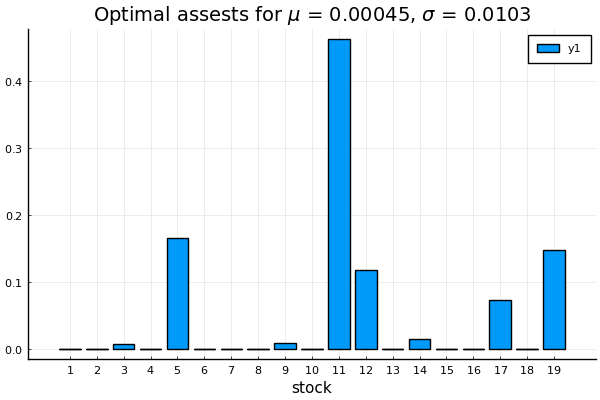

In [34]:
## Compute the minimum risk portfolio with different average returns
μ_min = 0.000350                               # Minimum expected average return  

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))  

## Variables
@variable(model, x[1:n] >= 0)                  # Stock positions

## Objective
@objective(model, Min, dot(x, Σ*x))            # Minimize variance

## Constraints
@constraint(model, dot(x,μ) >= μ_min)          # Expected average return bound
@constraint(model, sum(x) == 1)                # Scaling of stock positions

## Solve the problem and get solution
optimize!(model)
status = termination_status(model)
# println(status)

x   = value.(x)         # Stock positions
ret = dot(μ, x)         # Return
std = sqrt(dot(x,Σ*x))  # Risk: std. deviation of returns

## Plot optimal asset selection
Plots.bar(1:n, x,
          xticks = 1:1:n,
          title  = string("Optimal assests for \$ \\mu \$ = ", round(ret, digits = 5), ", \$ \\sigma \$ = ", round(std, digits = 5)),
          xlabel = "stock")       

### Compute optimal tradeoff curve for 50 equidistant points μ_min ∈ [0, 0.000869] for the problem

$\begin{align*}
\text{minimize} \quad & x^\top\Sigma x\\
\text{subject to}  \quad & \mu^\top x \geq \mu_{min}\\
		& \sum_{i\in N} x_i = 1\\
		& x \geq 0
\end{align*}$

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


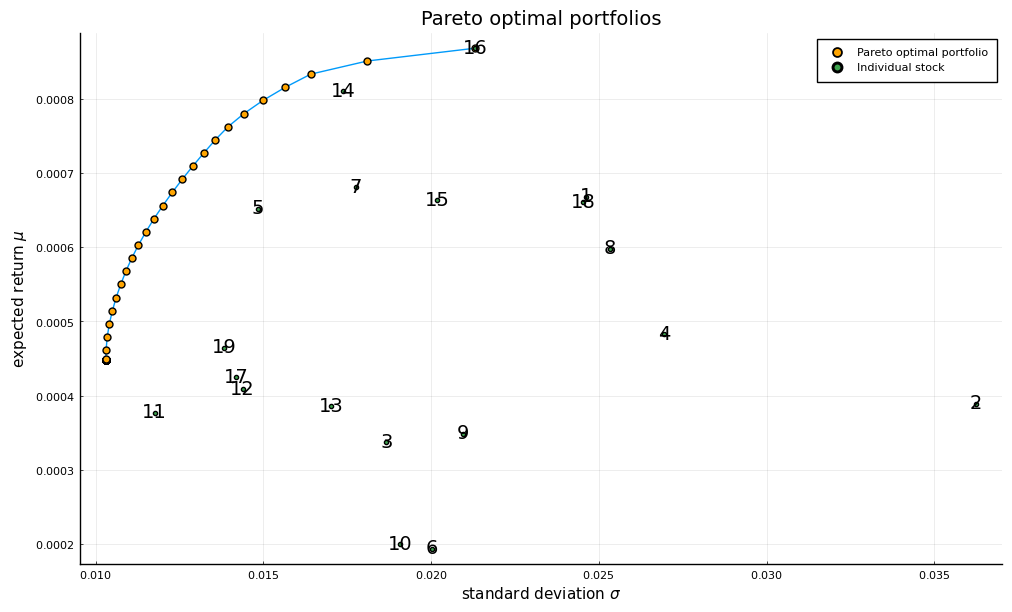

In [36]:
N   = 50                               # Number of points to compute
ret = zeros(N)                         # Array to save values of μ
std = zeros(N)                         # Array to save values of σ
μ_min_values = LinRange(0,0.000869,N)  # Range of 50 values μ_min ∈ [0, 0.000869]

for (i, μ_min) in enumerate(μ_min_values)
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))  
    @variable(model, x[1:n] >= 0)           # Stock positions
    @objective(model, Min, dot(x, Σ*x))     # Minimize variance
    @constraint(model, dot(x,μ) >= μ_min)   # Expected average return bound
    @constraint(model, sum(x) == 1)         # Scaling of stock positions
    
    ## Solve the problem and compute ret[i] and std[i] for the current μ_min value
    optimize!(model)
    x = value.(x)             # Get stock positions 
    ret[i] = dot(μ,x)         # Compute return 
    std[i] = sqrt(dot(x,Σ*x)) # Compute risk (stdandard deviation)
end

## Plot the tradeoff curve (Pareto front)
plot(std, ret, 
     xlabel = "standard deviation \$ \\sigma \$",
     ylabel = "expected return \$ \\mu \$",
     title  = "Pareto optimal portfolios",
     grid   = :on,
     lab    = "",
     size   = (1000, 600))
## Plot the individual portfolio points 
scatter!([std], [ret], color = :orange, markersize = 5, lab = "Pareto optimal portfolio")
savefig("pareto_front_portfolios.pdf")

## Plot the points (σᵢ,μᵢ) for all stocks  i ∈ N for comparison NOTE: One portfolio consists of one stock: 16
scatter!(σ, μ, color = :3, markersize = 3, lab = "Individual stock", series_annotations = string.(1:n))
savefig("pareto_front_portfolios_stocks.pdf")